In [2]:
import sys, os, cv2, json, math
import seaborn as sns
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt, pytz
from tqdm import tqdm
from itertools import combinations

In [3]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [4]:
%%script False --no-raise-error

# FIGURE
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 3))

# AXES
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# GRID
plt.grid(True)
plt.gca().set_axisbelow(True)

# LEGEND
handles = [plt.Rectangle((0,0),1,1, color=wbc_cmap[wbc]) for wbc in webcams]
plt.legend(handles, webcams, frameon=True, loc='upper left', handlelength=1, handleheight=1)

# SAVING
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/webcam-images-per-day.png", dpi=300)
plt.show()

Couldn't find program: 'False'


In [5]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('webcam_colormap.json').read())

In [6]:
df_all_images = pd.DataFrame()
for wbc in webcams:
    img_files = os.listdir(f"../../data/{wbc}")
    img_ts = [dt.datetime.strptime(img.split(".")[0], "%Y-%m-%d_%H-%M-%S") for img in img_files]
    img_ts = [pytz.timezone('Europe/Zurich').localize(ts) for ts in img_ts]
    img_files = pd.DataFrame({"filename": img_files, "timestamp": img_ts, "webcam": wbc})
    img_files.sort_values("timestamp", inplace=True)
    img_files.reset_index(drop=True, inplace=True)
    df_all_images = pd.concat([df_all_images, img_files])

In [7]:
df_all_images

,filename,timestamp,webcam
0,2024-08-29_12-00-00.jpg,2024-08-29 12:00:00+02:00,altenrhein
1,2024-08-30_04-00-00.jpg,2024-08-30 04:00:00+02:00,altenrhein
2,2024-08-30_04-20-00.jpg,2024-08-30 04:20:00+02:00,altenrhein
3,2024-08-30_04-40-00.jpg,2024-08-30 04:40:00+02:00,altenrhein
4,2024-08-30_05-00-00.jpg,2024-08-30 05:00:00+02:00,altenrhein
...,...,...,...
16575,2025-03-14_14-30-00.jpg,2025-03-14 14:30:00+01:00,wiler-turm
16576,2025-03-14_14-40-00.jpg,2025-03-14 14:40:00+01:00,wiler-turm
16577,2025-03-14_14-50-00.jpg,2025-03-14 14:50:00+01:00,wiler-turm
16578,2025-03-14_15-00-00.jpg,2025-03-14 15:00:00+01:00,wiler-turm


In [8]:
# calculate total amount of images per hour
df = df_all_images.copy()
df["datetime"] = pd.to_datetime(df["filename"].str.split(".").str[0], format="%Y-%m-%d_%H-%M-%S")
df = df[~pd.isna(df["datetime"])]
df["hour"] = df["datetime"].dt.hour.astype(int)

In [9]:
df["date"] = df["datetime"].dt.date
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['season'] = df['month'].apply(assign_season)


In [10]:
df['ymd'] = df['datetime'].dt.strftime('%Y-%m-%d')

In [11]:
df[['webcam', "timestamp", 'season', 'hour', "ymd"]].groupby(['webcam', 'hour', 'season', "ymd"]).count()

timestamp
webcam     hour season ymd                  
altenrhein 4    Fall   2024-09-01          3
                       2024-09-02          3
                       2024-09-03          3
                       2024-09-04          3
                       2024-09-05          2
...                                      ...
wiler-turm 23   Fall   2024-09-19          3
                       2024-09-20          3
                       2024-09-21          3
                       2024-09-22          3
                       2024-09-23          3

[28179 rows x 1 columns]

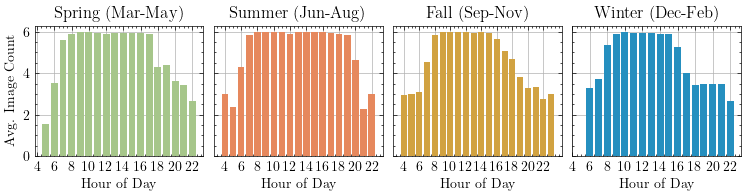

In [14]:
# Example aggregated DataFrame preparation
grouped_df = df[['webcam', "timestamp", 'season', 'hour', "ymd"]].groupby(['webcam', 'hour', 'season', "ymd"]).count().reset_index()

# Compute average per hour per season, considering only active webcam-days
agg = (
    grouped_df
    .groupby(['season', 'hour'])
    .agg(avg_image_count_per_webcam_day=('timestamp', 'mean'))
    .reset_index()
)

# Define seasons, months, and colors in matching order
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
months = ['Mar-May', 'Jun-Aug', 'Sep-Nov', 'Dec-Feb']
colors = ['#a6c68a', '#e6885d', '#d1a241', '#258fbf']

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(FIG_WIDTH, 2), sharey=True)

for i, (season, month, color) in enumerate(zip(seasons, months, colors)):
    ax = axes[i]
    season_data = agg[agg['season'] == season]
    ax.bar(season_data['hour'], season_data['avg_image_count_per_webcam_day'], color=color)
    ax.set_title(f'{season} ({month})')
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Avg. Image Count')
    ax.set_xticks(range(4, 24, 2))
    ax.grid(True)
    ax.set_axisbelow(True)

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/amount-hour-avg-per-season.png", dpi=300)
plt.show()